# Merging RBD-Ab affinity scores and expression data for downstream `torchdms` analysis (still under construction)

This notebook provides some of the pre-processin and summary statistics for the CCG DMS data which will be used for training a model downstream. 

In [75]:
# Imports
import pickle
import json
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
%matplotlib inline

## 1: Merge and clean raw data

In [76]:
# directory where all all input and output is organized
data_dir = "data/tdms_models/raw_dms/"

# other relative paths
wt_seq_path = f"{data_dir}/wildtype_sequence.fasta"
raw_bind = f"{data_dir}/bc_binding.csv"
raw_expr = f"{data_dir}/bc_expression.csv"
raw_poly = f"{data_dir}/bc_polyspecificity.csv"
# figure_output_dir = f"{data_dir}/figures/"

In [77]:
raw_cols = ['log10Ka', 'expression', 'polyspecificity_02']
raw_dfs = [pd.read_csv(raw_bind), pd.read_csv(raw_expr), pd.read_csv(raw_poly)]
new_cols = ["bind", "stab", "poly"]

In [78]:
# Sequence information from Tyler's repo
record = SeqIO.read(wt_seq_path, 'fasta')
dna_seq = record.seq     
wtseq = dna_seq.translate()
len(wtseq)

235

**now let's merge the scores into a single df**

In [79]:
full_df = reduce(
        lambda l, r: pd.merge(l, r, how='inner',
            on=['library','target', 'barcode', 'variant_class', 'aa_substitutions','n_aa_substitutions'],
            sort=False
        ),
        raw_dfs,
    ).rename(dict(zip(raw_cols, new_cols)), axis=1)

full_df.aa_substitutions = full_df.aa_substitutions.fillna(' ')
full_df.n_aa_substitutions = [len(s.split()) for s in full_df.aa_substitutions.values]

In [80]:
full_df[new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192429 entries, 0 to 192428
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bind    140191 non-null  float64
 1   stab    175070 non-null  float64
 2   poly    150390 non-null  float64
dtypes: float64(3)
memory usage: 5.9 MB


In [81]:
to_drop_query = " & ".join([f"{target}.notnull()" for target in new_cols])
full_df = full_df.query(to_drop_query)

In [82]:
full_df[new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131617 entries, 0 to 192428
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bind    131617 non-null  float64
 1   stab    131617 non-null  float64
 2   poly    131617 non-null  float64
dtypes: float64(3)
memory usage: 4.0 MB


In [83]:
full_df.variant_class.value_counts()

1 nonsynonymous     104903
wildtype             16728
>1 nonsynonymous      9515
synonymous             471
Name: variant_class, dtype: int64

In [84]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131617 entries, 0 to 192428
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   library             131617 non-null  object 
 1   barcode             131617 non-null  object 
 2   target              131617 non-null  object 
 3   variant_class       131617 non-null  object 
 4   aa_substitutions    131617 non-null  object 
 5   n_aa_substitutions  131617 non-null  int64  
 6   TiteSeq_avgcount    131617 non-null  float64
 7   bind                131617 non-null  float64
 8   expr_count          131617 non-null  float64
 9   stab                131617 non-null  float64
 10  psr_count_01        127766 non-null  float64
 11  polyspecificity_01  125939 non-null  float64
 12  psr_count_02        131617 non-null  float64
 13  poly                131617 non-null  float64
 14  psr_count_03        125686 non-null  float64
 15  polyspecificity_03  124118 non-nul

## 2: WT summary stats

now, we'll take a look at the wildtype dummary stats to get an idea of the variance among many replicates, and to get an idea of difference when compared to mutants of various strata (N-mutations). This is because we want to predict delta's (change in affinity) of mutants when compared to the wildtype. We also want to know about any batch-specific differences between the two libraries being used

In [85]:
# non-synonymous mutants count as wildtype.
wt_df = full_df.query("n_aa_substitutions == 0")

In [86]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17199 entries, 10 to 192426
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   library             17199 non-null  object 
 1   barcode             17199 non-null  object 
 2   target              17199 non-null  object 
 3   variant_class       17199 non-null  object 
 4   aa_substitutions    17199 non-null  object 
 5   n_aa_substitutions  17199 non-null  int64  
 6   TiteSeq_avgcount    17199 non-null  float64
 7   bind                17199 non-null  float64
 8   expr_count          17199 non-null  float64
 9   stab                17199 non-null  float64
 10  psr_count_01        16814 non-null  float64
 11  polyspecificity_01  16645 non-null  float64
 12  psr_count_02        17199 non-null  float64
 13  poly                17199 non-null  float64
 14  psr_count_03        16573 non-null  float64
 15  polyspecificity_03  16386 non-null  float64
 16  ps

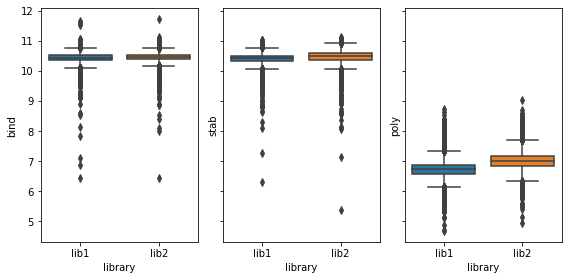

In [87]:
fig, ax = plt.subplots(1,3, figsize=[8,4],sharex=True, sharey=True)
for col, metric in enumerate(new_cols):
    sns.boxplot(x="library", y=metric, data=wt_df, ax=ax[col])
plt.tight_layout()
plt.show()

## 3: Mutant summary stats

In [88]:
# calculate deltas from wt
mutants = full_df.query("n_aa_substitutions != 0").copy()

In [89]:
mutants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114418 entries, 0 to 192428
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   library             114418 non-null  object 
 1   barcode             114418 non-null  object 
 2   target              114418 non-null  object 
 3   variant_class       114418 non-null  object 
 4   aa_substitutions    114418 non-null  object 
 5   n_aa_substitutions  114418 non-null  int64  
 6   TiteSeq_avgcount    114418 non-null  float64
 7   bind                114418 non-null  float64
 8   expr_count          114418 non-null  float64
 9   stab                114418 non-null  float64
 10  psr_count_01        110952 non-null  float64
 11  polyspecificity_01  109294 non-null  float64
 12  psr_count_02        114418 non-null  float64
 13  poly                114418 non-null  float64
 14  psr_count_03        109113 non-null  float64
 15  polyspecificity_03  107732 non-nul

## 4: Calculate delta's from wildtype average.

$\Delta$ $M_{Pi}$ = $M_{Pi}$ - ($1/N$ $\sum_{n=0}^{N}{WT}_{Pn}$)

In [90]:
for lib, lib_df in wt_df.groupby("library"):
    print(lib)
    for metric in new_cols:
        mean_lib_metric = round(np.mean(lib_df[metric]), 5)
        print(f"  mean {metric}: {mean_lib_metric}")
        mutants[f"delta_{metric}"] = mutants[metric] - mean_lib_metric

lib1
  mean bind: 10.41097
  mean stab: 10.40787
  mean poly: 6.72826
lib2
  mean bind: 10.44162
  mean stab: 10.46162
  mean poly: 7.02015


## 5: Bacode replicate summary stats 

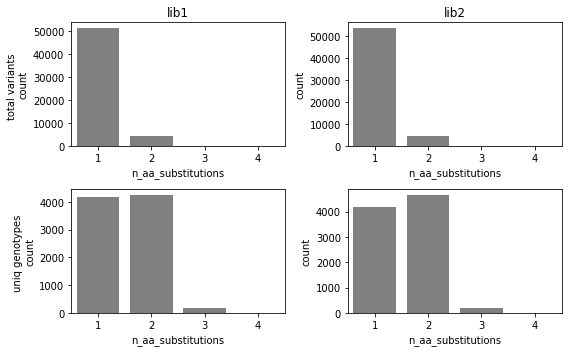

In [91]:
# How many unique variants are in the library by codon-substution number?
fig, ax = plt.subplots(2,2, figsize=[8, 5])
for i,(lib, lib_df) in enumerate(mutants.groupby('library')):
    uniq_geno_lib_df = lib_df.groupby("aa_substitutions").first()
    sns.countplot(data=uniq_geno_lib_df, x='n_aa_substitutions', color="gray", ax=ax[1, i])
    sns.countplot(data=lib_df, x="n_aa_substitutions", color="gray", ax=ax[0, i])
    ax[0, i].set_title(lib)

ax[0, 0].set_ylabel("total variants \ncount")
ax[1, 0].set_ylabel("uniq genotypes \ncount")
plt.tight_layout()
plt.show()

## 6: Aggragate barcodes for mutants

In [92]:
mean_collapsed_mutants = mutants.groupby(['library', 'variant_class', 'aa_substitutions']).mean().reset_index()

17,615 total examples in mean collapsed where delta bind, stab, and poly are non null.

In [93]:
datas = {
    "Mutants\n(separate)" :  mutants,
    "Mutants\n(Collapsed By Barcode)": mean_collapsed_mutants,
#     "Wildtype": wt_df
}

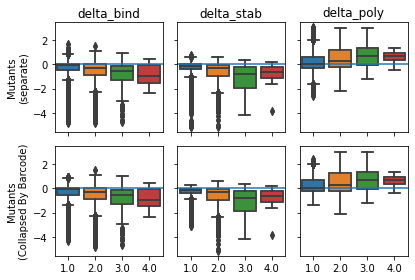

In [94]:
# # plot 
# TODO add more stats and cleaup
new_cols_delta = [f"delta_{c}" for c in new_cols]

fig, ax = plt.subplots(len(datas),3, figsize=[6, 4], sharex=True, sharey=True)
for col, metric in enumerate(new_cols_delta):
    for row, (key, value) in enumerate(datas.items()):
        cur_ax = ax[row, col] if len(datas) > 1 else ax[col]
        sns.boxplot(x="n_aa_substitutions", y=metric, data=value, ax=cur_ax)
        sns.boxplot(x="n_aa_substitutions", y=metric, data=value, ax=cur_ax)
        cur_ax.set_ylabel("")
        cur_ax.set_xlabel("")

        if row == 0:
            cur_ax.set_title(metric)

        if col == 0:
            cur_ax.set_ylabel(key)

        cur_ax.axhline()

        
# ax[].set_xlabel("N AA SUBS")
fig.xlabel = "N AA Subs"
plt.tight_layout()

plt.show()

# 8: octet data

**load the octet data and convert the mutations to tdms format**

In [98]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")

octet_df = pd.read_csv(f"{data_dir}/octet_data.csv")
for row_idx, row in octet_df.iterrows():
    igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
    igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
    
    all_mutations = igh_mutations + igk_mutations
    converted_mutations = []
    
    aa_seq = pos_df.amino_acid.copy()
    for mutation in all_mutations:
        chain = mutation[-3]
        pos = int(mutation[1:-4])
        wildtype = mutation[0]
        mutant = mutation[-1]
        idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
        assert len(idx) == 1
        idx = idx[0]
        assert aa_seq[idx] == wildtype
        converted_mutations.append("".join([wildtype, str(idx), mutant]))
    octet_df.loc[row_idx, "aa_substitutions"] = " ".join(converted_mutations) 
    
octet_df["delta_bind"] = np.log10(octet_df.octet_Kd_foldchange_avg)
octet_df["library"] = "octet"
octet_df_tdms = octet_df[["library", "delta_bind","aa_substitutions", "aa_mut_total"]].rename({"aa_mut_total":"n_aa_substitutions"}, axis=1)
octet_df_tdms

,library,delta_bind,aa_substitutions,n_aa_substitutions
0,octet,0.803749,K44R Y53F A161G,3
1,octet,0.842167,A161G,1
2,octet,-0.192064,A161V,1
3,octet,-0.423735,A161V N219D,2
4,octet,0.761498,D27A,1
5,octet,2.488822,D27A K39R S56G A161G Y163F A173S Q216H N219Y,8
6,octet,2.583760,D27A K44R S56G A161G Y163F A173S Q216H N219Y,8
7,octet,2.557845,D27A K39R K44R S56G A161G Y163F A173S Q216H N219Y,9
8,octet,0.000000,,0
9,octet,-0.005882,K39R,1


**merge it with the training data**

In [99]:
tdms_data = mean_collapsed_mutants[["library", "delta_bind", "aa_substitutions", "n_aa_substitutions"]]
tdms_data = pd.concat([tdms_data, octet_df_tdms], ignore_index=True)
tdms_data

,library,delta_bind,aa_substitutions,n_aa_substitutions
0,lib1,0.006203,A104C,1.0
1,lib1,-0.171476,A104D,1.0
2,lib1,-0.116416,A104E,1.0
3,lib1,-0.088985,A104F,1.0
4,lib1,-0.082625,A104G,1.0
...,...,...,...,...
17638,octet,0.370343,N219Y,1.0
17639,octet,0.753072,Q216H N219Y,2.0
17640,octet,-0.226826,N219D,1.0
17641,octet,1.927590,K44R A161G Y163F A173S N219S,5.0


In [100]:
octet_df_tdms.n_aa_substitutions.value_counts()

1    13
8     3
4     3
5     3
3     2
2     2
9     1
0     1
Name: n_aa_substitutions, dtype: int64

<AxesSubplot:xlabel='n_aa_substitutions', ylabel='delta_bind'>

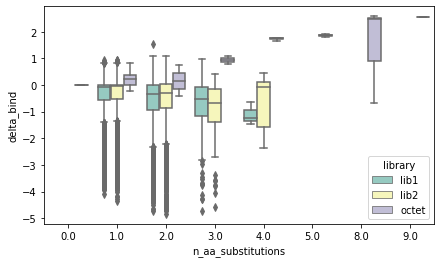

In [101]:
fig, ax = plt.subplots(figsize=[7, 4])
sns.boxplot(x="n_aa_substitutions", y="delta_bind", hue="library",
                 data=tdms_data, palette="Set3", ax = ax)

**Write to disk**

In [102]:
with open("data/tdms_models/" + str(date.today()) + "-tstarr-dms-tatsuya-octet-bind-only.pkl", "wb") as f:
    pickle.dump([tdms_data, str(wtseq)], f)

# 9: train & test tdms model

**prep the data for tdms training**

In [103]:
! tdms prep \
    --per-stratum-variants-for-test 1 \
    --skip-stratum-if-count-is-smaller-than 3 \
    --train-on-all-single-mutants \
    data/tdms_models/$(date -I)-tstarr-dms-tatsuya-octet-bind-only.pkl \
    data/tdms_models/$(date -I)-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl \
    delta_bind

LOG: Targets: ('delta_bind',)
LOG: There are 17643 total variants in this dataset
LOG: placing all single mutants in training dataset as requested.
LOG: There are 8361 training samples for stratum: 1
LOG: There are 8912 training samples for stratum: 2
LOG: There are 347 training samples for stratum: 3
LOG: There are 9 training samples for stratum: 4
LOG: There are 1 training samples for stratum: 5
LOG: There are 1 training samples for stratum: 8
LOG: There are 5 validation samples
LOG: There are 5 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset
LOG: Successfully finished prep and dumped SplitDataset object to data/tdms_models/2022-03-29-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl


In [104]:
! ls data/tdms_models/

2021-11-29-CGG
2022-03-27-tstarr-dms-tatsuya-octet-bind-only.pkl
2022-03-27-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl.pkl
2022-03-28-tstarr-dms-tatsuya-octet-bind-only.pkl
2022-03-28-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl.pkl
2022-03-29-tstarr-dms-tatsuya-octet-bind-only.pkl
2022-03-29-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl.pkl
mse.model
option.json
prep-commands.txt
raw_dms


**define the model**

In [105]:
model_config = {
    "default": {
        "data_path": "data/tdms_models/2022-03-27-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl.pkl",
        "epochs": 400,
        "independent_starts": 5,
        "include_details": "true",
        "loss_fn": "mse",
        "non_lin_bias" : "false",
        "output_bias" : "false",
        "device" : "cpu",
        "model_string": "FullyConnected;[2,3];[None,'relu']",
        "prefix": "output/tdms/vanilla",
        "seed": 10
    }
}
with open("data/tdms_models/option.json", "w") as outfile:
    json.dump(model_config, outfile, indent=4)

In [106]:
! cat data/tdms_models/option.json

{
    "default": {
        "data_path": "data/tdms_models/2022-03-27-tstarr-dms-tatsuya-octet-bind-only.prepped.pkl.pkl",
        "epochs": 400,
        "independent_starts": 5,
        "include_details": "true",
        "loss_fn": "mse",
        "non_lin_bias": "false",
        "output_bias": "false",
        "device": "cpu",
        "model_string": "FullyConnected;[2,3];[None,'relu']",
        "prefix": "output/tdms/vanilla",
        "seed": 10
    }
}

**fit the model**

In [107]:
! tdms go --config data/tdms_models/option.json

LOG: Setting random seed to 10.
LOG: Model defined as: FullyConnected(
  (latent_layer): Linear(in_features=4935, out_features=2, bias=False)
  (nonlinearity_1): Linear(in_features=2, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)
{'activations': '[Identity(), <built-in method relu of type object at 0x7fcf5f01e1e0>]', 'monotonic': None, 'beta_l1_coefficient': 0.0, 'interaction_l1_coefficient': 0.0, 'non-linearity bias parameters': 'false', 'output bias': 'false'}
LOG: Saved model to output/tdms/vanilla.model
LOG: Setting random seed to 10.
Starting training. {'independent_start_count': 5, 'independent_start_epoch_count': None, 'epoch_count': 400, 'loss_fn': <function weighted_loss.<locals>.wrapper at 0x7fcef003e3a0>, 'patience': 10, 'min_lr': 1e-05, 'loss_weight_span': None, 'exp_target': None, 'beta_rank': None}
LOG: Independent start 1/5
Training in default style.
  [------------------------------------]    0%
validation loss record: 2

  [#########################-----------]   70%  00:00:07
validation loss record: 1.783639907836914
  [##########################----------]   72%  00:00:06
validation loss record: 1.7701785564422607
  [###########################---------]   75%  00:00:05
validation loss record: 1.732265830039978
  [###########################---------]   77%  00:00:05
validation loss record: 1.7041823863983154
  [############################--------]   80%  00:00:04
validation loss record: 1.6792720556259155
  [#############################-------]   82%  00:00:04
validation loss record: 1.6621042490005493
  [##############################------]   85%  00:00:03
validation loss record: 1.6410144567489624
  [###############################-----]   87%  00:00:03
validation loss record: 1.6124191284179688
  [################################----]   90%  00:00:02
validation loss record: 1.5922603607177734
  [#################################---]   92%  00:00:01
validation loss record: 1.5736610889434814
  

  [####################----------------]   57%  00:00:10
validation loss record: 0.05931286886334419
  [#####################---------------]   60%  00:00:10
validation loss record: 0.057368259876966476
  [######################--------------]   62%  00:00:09
validation loss record: 0.054334867745637894
  [#######################-------------]   65%  00:00:09
validation loss record: 0.053602706640958786
  [########################------------]   67%  00:00:08
validation loss record: 0.05168633908033371
  [#########################-----------]   70%  00:00:07
validation loss record: 0.04969338700175285
  [##########################----------]   72%  00:00:07
validation loss record: 0.048714715987443924
  [###########################---------]   75%  00:00:06
validation loss record: 0.04794914275407791
  [###########################---------]   77%  00:00:05
validation loss record: 0.04657138139009476
  [############################--------]   80%  00:00:05
validation loss record: 0.0448

In [32]:
! ls output/tdms

vanilla.beta.pdf	   vanilla.heat.pdf	      vanilla.scatter.pdf
vanilla.error.csv	   vanilla.model	      vanilla.sentinel
vanilla.error.pdf	   vanilla.model_details.pkl  vanilla.svd.pdf
vanilla.error-summary.csv  vanilla.profiles.pdf
vanilla.ge.pdf		   vanilla.scatter.corr.csv


In [33]:
! cat output/tdms/vanilla.error.csv

observed,predicted,n_aa_substitutions,target,abs_error,observed_quality
-2.675475,-0.59558195,2,delta_bind,2.0798929,1
-1.461828,0.047135413,4,delta_bind,1.5089633,1
0.075585,-0.7624685,3,delta_bind,0.8380535,2
-0.66437185,2.0954483,8,delta_bind,2.75982,2
1.811829,1.8870027,5,delta_bind,0.075173736,2


**look at test results - did we break the wall?**

<AxesSubplot:xlabel='predicted', ylabel='observed'>

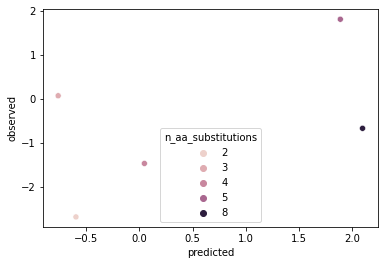

In [34]:
results = pd.read_csv("output/tdms/vanilla.error.csv")
sns.scatterplot(data=results, y="observed", x="predicted", hue="n_aa_substitutions")

# 10: predict on new data

In [35]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


In [36]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon
site_scFv,,,,
1,E,H,1,GAG
2,V,H,2,GTG
3,Q,H,3,CAG
4,L,H,4,CTT
5,Q,H,5,CAG
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


In [37]:
pos_df.loc[(pos_df.chain == "H") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "H") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "H") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "H") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "H") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "H") & (105 <= pos_df.site) & (pos_df.site <= 110), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "H") & (111 <= pos_df.site), "region"] = "FR4"

pos_df.loc[(pos_df.chain == "L") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "L") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "L") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "L") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "L") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "L") & (105 <= pos_df.site) & (pos_df.site <= 113), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "L") & (114 <= pos_df.site) & (pos_df.site <= 123), "region"] = "FR4"

# pos_df.to_csv("output/CGGnaive_sites_annotated.csv")
pos_df

,amino_acid,chain,site,KI_codon,region
site_scFv,,,,,
1,E,H,1,GAG,FR1
2,V,H,2,GTG,FR1
3,Q,H,3,CAG,FR1
4,L,H,4,CTT,FR1
5,Q,H,5,CAG,FR1
...,...,...,...,...,...
231,L,L,120,CTA,FR4
232,E,L,121,GAA,FR4
233,I,L,122,ATA,FR4


In [38]:
! ls ../../data/2021-11-29-CGG/tdms_models/

ls: cannot access '../../data/2021-11-29-CGG/tdms_models/': No such file or directory


In [39]:
tdms_model = torch.load(f"output/tdms/vanilla.model", map_location=torch.device('cpu'))
tdms_model.eval

<bound method Module.eval of FullyConnected(
  (latent_layer): Linear(in_features=4935, out_features=2, bias=False)
  (nonlinearity_1): Linear(in_features=2, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)>

In [40]:
for row_idx, row in octet_df.iterrows():
    igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
    igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
    all_mutations = igh_mutations + igk_mutations
    if any("*" in x for x in all_mutations):
        delta_bind = None
    else:
        delta_bind = dms_df.delta_bind[all_mutations].sum()
    octet_df.loc[row_idx, "delta_bind_additive"] = delta_bind
    
    aa_seq = pos_df.amino_acid.copy()
#     print(aa_seq)
    for mutation in all_mutations:
        chain = mutation[-3]
        pos = int(mutation[1:-4])
        wildtype = mutation[0]
        mutant = mutation[-1]
        idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
        assert len(idx) == 1
        idx = idx[0]
        assert aa_seq[idx] == wildtype
        aa_seq[idx] = mutant
#     print(tdms_model.seq_to_binary("".join(aa_seq)).sum())
    tdms_prediction = tdms_model(tdms_model.seq_to_binary("".join(aa_seq))).detach()# - tdms_prediction_naive
    octet_df.loc[row_idx, "delta_bind_tdms"] = tdms_prediction[0].item()

In [41]:
octet_df["delta_bind_octet"] = np.log10(octet_df.octet_Kd_foldchange_avg)
    
octet_df

,ID,HCmut,LCmut,aa_mut_total,deltaKd_additive_foldchange,deltaKd_additive,octet_Kd_foldchange_avg,kd,kon,kdis,R^2,aa_substitutions,delta_bind,library,delta_bind_additive,delta_bind_tdms,delta_bind_octet
0,#26 Fab4,"K49R, Y58F",A40G,3,7.462082,0.87286,6.364276,2.840000e-09,126300,0.000359,0.9993,K44R Y53F A161G,0.803749,octet,0.87286,0.827952,0.803749
1,A40G,GL,A40G,1,7.172326,0.85566,6.952912,4.210000e-09,90900,0.000383,0.9997,A161G,0.842167,octet,0.85566,0.077279,0.842167
2,A40V,GL,A40V,1,0.193201,-0.71399,0.642593,5.400000e-08,142000,0.007670,0.9746,A161V,-0.192064,octet,-0.71399,-1.095002,-0.192064
3,"A40V, N108D",GL,"A40V, N108D",2,0.031422,-1.50277,0.376934,7.110000e-08,111000,0.007920,0.9266,A161V N219D,-0.423735,octet,-1.50277,-1.364358,-0.423735
4,D28A,D28A,GL,1,6.835810,0.83479,5.774278,3.810000e-09,225000,0.000858,0.9944,D27A,0.761498,octet,0.83479,-0.285616,0.761498
5,EH1,"D28A, K44R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2558.998315,3.40807,308.192458,7.690000e-11,933000,0.000072,0.9919,D27A K39R S56G A161G Y163F A173S Q216H N219Y,2.488822,octet,3.40807,2.508376,2.488822
6,EH2,"D28A, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2154.269337,3.33330,383.495146,6.180000e-11,1030000,0.000063,0.9947,D27A K44R S56G A161G Y163F A173S Q216H N219Y,2.583760,octet,3.33330,2.762382,2.583760
7,EH3,"D28A, K44R, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",9,2499.769702,3.39790,361.280488,6.560000e-11,1050000,0.000069,0.9900,D27A K39R K44R S56G A161G Y163F A173S Q216H N219Y,2.557845,octet,3.39790,2.973976,2.557845
8,GL,GL,GL,0,1.000000,0.00000,1.000000,2.600000e-08,86700,0.002260,0.9900,,0.000000,octet,0.00000,-0.404811,0.000000
9,K44R,K44R,GL,1,1.160379,0.06460,0.986547,2.230000e-08,152000,0.003400,0.9950,K39R,-0.005882,octet,0.06460,-0.271112,-0.005882


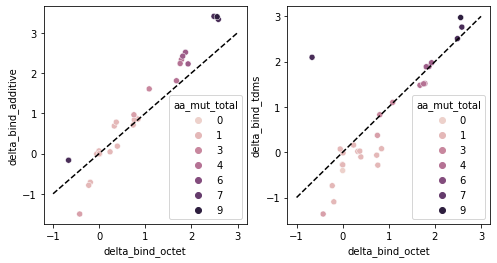

In [42]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
sns.scatterplot(data=octet_df, y="delta_bind_additive", x="delta_bind_octet", hue="aa_mut_total", ax = ax[0])
ax[0].plot((-1, 3), (-1, 3), 'k--')
sns.scatterplot(data=octet_df, y="delta_bind_tdms", x="delta_bind_octet", hue="aa_mut_total", ax = ax[1])
ax[1].plot((-1, 3), (-1, 3), 'k--')
fig.savefig("output/plots/octet_addit_tdms.pdf")

## Compare TorchDMS to naive additive model

on tree nodes

In [56]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


## Position maps for scFv

In [57]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon
site_scFv,,,,
1,E,H,1,GAG
2,V,H,2,GTG
3,Q,H,3,CAG
4,L,H,4,CTT
5,Q,H,5,CAG
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


In [58]:
pos_df[(pos_df.chain=="L")]

,amino_acid,chain,site,KI_codon
site_scFv,,,,
128,D,L,1,GAC
129,I,L,2,ATT
130,V,L,3,GTG
131,M,L,4,ATG
132,T,L,5,ACT
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


### Add CDR/FWR annotations from IMGT VQUEST

In [59]:
pos_df.loc[(pos_df.chain == "H") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "H") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "H") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "H") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "H") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "H") & (105 <= pos_df.site) & (pos_df.site <= 110), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "H") & (111 <= pos_df.site), "region"] = "FR4"

pos_df.loc[(pos_df.chain == "L") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "L") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "L") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "L") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "L") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "L") & (105 <= pos_df.site) & (pos_df.site <= 113), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "L") & (114 <= pos_df.site) & (pos_df.site <= 123), "region"] = "FR4"

pos_df.to_csv("output/CGGnaive_sites_annotated.csv")
pos_df

,amino_acid,chain,site,KI_codon,region
site_scFv,,,,,
1,E,H,1,GAG,FR1
2,V,H,2,GTG,FR1
3,Q,H,3,CAG,FR1
4,L,H,4,CTT,FR1
5,Q,H,5,CAG,FR1
...,...,...,...,...,...
231,L,L,120,CTA,FR4
232,E,L,121,GAA,FR4
233,I,L,122,ATA,FR4


In [60]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

In [61]:
import glob

In [62]:
date = "2022-03-28"

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"../nextflow/results/{date}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 74 GC trees


In [63]:
! ls ../nextflow/results

2022-03-22  2022-03-28


**cell counts per gc**

<BarContainer object of 74 artists>

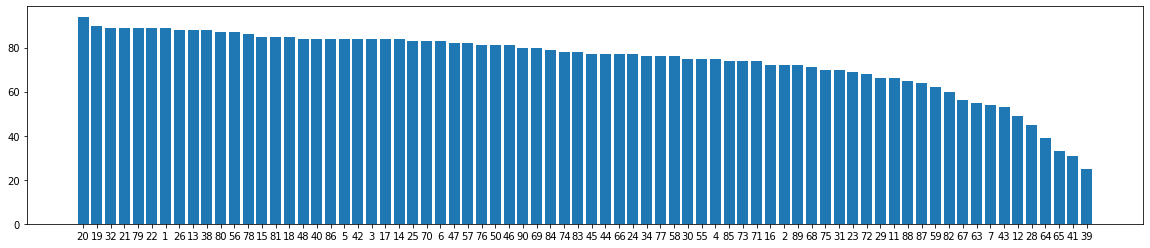

In [64]:
observed_bcrs = pd.read_csv(f"../nextflow/results/{date}/merged-results/observed-seqs.csv")
fig, ax = plt.subplots(figsize=[20, 4])
vc = observed_bcrs.HK_key_gc.value_counts().drop(0)
ax.bar([str(gc) for gc in vc.index], height=vc.values)

In [65]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

In [66]:
τ = 1
τ0 = 0.1

In [67]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def tree_nt_seq_to_dms_aa_seq(sequence):

    igh_aa = aa(sequence[:igk_idx], igh_frame)
    igk_aa = aa(sequence[igk_idx:], igk_frame)

    aa_dms = pos_df.amino_acid.copy()
    aa_dms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_dms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    
    return "".join(aa_dms)

In [68]:
# trees_df = pd.DataFrame()

for gc, tree in trees.items():
    
    # rename tuple names with last element of tuple (possible danger)
    if isinstance(tree.tree.name, tuple):
        tree.tree.name = tree.tree.name[-1]
    
    tree.local_branching(tau=τ, tau0=τ0)

    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    for node in tree.tree.traverse():

        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
        all_mutations = igh_mutations + igk_mutations
        if any("*" in x for x in all_mutations):
            delta_bind = np.nan
            delta_expr = np.nan
            delta_psr = np.nan
        else:
            delta_bind = dms_df.delta_bind[all_mutations].sum()
            delta_expr = dms_df.delta_expr[all_mutations].sum()
            delta_psr = dms_df.delta_psr[all_mutations].sum()

        node.add_feature("delta_bind_additive", delta_bind)
        node.add_feature("delta_expr_additive", delta_expr)
        node.add_feature("delta_psr_additive", delta_psr)
            
        tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node.sequence))).detach()# - tdms_prediction_naive
        
        node.add_feature("delta_bind_tdms", tdms_prediction[0].item())

In [69]:
min((node.delta_bind_additive, (gc, node.name)) for gc, tree in trees.items() for node in tree.tree.traverse() if node.abundance)
        

(-12.195310000000001, ('mouse8_GC87', 'seq46'))

In [70]:
rows = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if node.abundance:
            rows.append([node.delta_bind_tdms, node.delta_bind_additive])
#             rows.append([node.delta_bind_tdms, node.delta_bind_additive, node.delta_expr_tdms, node.delta_expr_additive])
            
tdmsVSadditive_df = pd.DataFrame(rows, columns=["delta_bind_tdms", "delta_bind_additive"])
# tdmsVSadditive_df = pd.DataFrame(rows, columns=["delta_bind_tdms", "delta_bind_additive", "delta_expr_tdms", "delta_expr_additive"])
tdmsVSadditive_df

,delta_bind_tdms,delta_bind_additive
0,-0.193704,-0.06082
1,0.136539,-3.45668
2,-0.687803,-0.80796
3,-0.852213,-1.52301
4,-1.693255,-9.09012
...,...,...
4900,3.033600,1.85844
4901,1.354945,2.05805
4902,1.309710,2.05647
4903,2.049483,2.11229


In [71]:
def single_mut_seq(row):
    aa_seq = pos_df.amino_acid.copy()
    assert aa_seq[row.position] == row.wildtype
    aa_seq[row.position] = row.mutant
    aa_seq = "".join(aa_seq)
    tdms_prediction = tdms_model(tdms_model.seq_to_binary(aa_seq)).detach()# - tdms_prediction_naive
#     return tdms_prediction[0]
    return tdms_prediction

dms_df[["delta_bind_tdms"]] = dms_df.apply(single_mut_seq, axis=1, result_type="expand")
# dms_df[["delta_bind_tdms", "delta_expr_tdms"]] = dms_df.apply(single_mut_seq, axis=1, result_type="expand")

dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site,delta_bind_tdms
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001,-0.183789
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001,-0.460308
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001,-0.054701
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001,-0.404811
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001,-0.224560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124,-0.563927
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124,-0.278615
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124,-0.289122


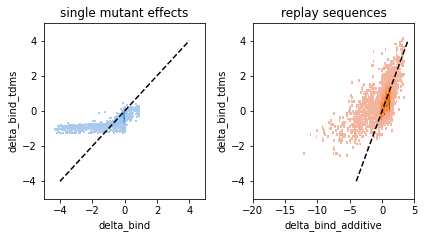

In [74]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
g = sns.histplot(data=dms_df, x="delta_bind", y="delta_bind_tdms", color="C0")
plt.plot((-4, 4), (-4, 4), 'k--',)
g.set_xlim(-5, 5)
g.set_ylim(-5, 5)
plt.title("single mutant effects")

plt.subplot(2, 2, 2)
g = sns.histplot(data=tdmsVSadditive_df, x="delta_bind_additive", y="delta_bind_tdms", color="C1")
plt.plot((-4, 4), (-4, 4), 'k--',)
g.set_xlim(-20, 5)
g.set_ylim(-5, 5)
plt.title("replay sequences")


plt.tight_layout()
plt.savefig("output/plots/tdms_Vs_additive_tr_oct.pdf")
plt.show()


In [ ]:
# TODO, there a few things we could throw out of the dataframe if we wanted to (like the other poly's)

# with open(str(date.today()) + "-tstarr-AbCGG-bind-expr-sep-seq-reps.pkl", "wb") as f:
#     pickle.dump([mutants, str(wtseq)], f)

# with open(str(date.today()) + "-tstarr-AbCGG-bind-expr-mean-seq-reps.pkl", "wb") as f:
#     pickle.dump([mean_collapsed, str(wtseq)], f)